# Package Functionalities Demo:

## Preparation: load data, functions, libraries of dependency...

In [1]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl"

In [2]:
cd("test")

In [3]:
using BenchmarkTools, Plots
using CSV, DelimitedFiles, DataFrames, Missings, LinearAlgebra, Statistics, Optim, Random, Distributions, LoopVectorization

In [4]:
include("../src/readData.jl");
include("../src/kinship.jl");
include("generate_test_bxdData.jl");
include("../src/scan.jl");
include("../src/bulkscan.jl");
include("../src/util.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/transform_helpers.jl");
include("testHelpers.jl");

In [5]:
traitID = 7919;
pheno_y = reshape(pheno[:, traitID], :, 1);

## 1. Simple Univariate Scans:

Given the raw phenotype info of one trait, the genotype info and the corresponding pre-calculated kinship matrix, return the lod scores of all genetic markers on that particular trait.

In [6]:
?scan;

### Assumption (1): VCs are estimated once from the null model

In [7]:
?scan_null;

In [8]:
@time test_null = scan(pheno_y, geno, kinship; addIntercept = true, reml = false, assumption = "null", method = "cholesky");

  0.022315 seconds (73.55 k allocations: 33.190 MiB)


In [9]:
test_null.sigma2_e # sigma2_e

0.04983520992588347

In [10]:
test_null.h2_null

0.8960637228416714

In [11]:
test_null.lod

7321-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360229954236
 0.008195284184264295
 0.00987347031983854
 ⋮
 0.09285575916070832
 0.09285575883025671
 0.09285575883025671
 0.011173043848082764
 0.008215696058314959
 0.008215696058314959
 0.01502332773404691
 0.02895771332730057
 0.02731129976924651
 0.04498777747884275
 0.012828276502853786
 0.012828276502853786

### Assumption (2): VCs are re-estimated everytime for each marker scan

In [12]:
?scan_alt;

In [13]:
@time test_alt = scan(pheno_y, geno, kinship; addIntercept = true, reml = false, assumption = "alt", method = "cholesky");

  0.703768 seconds (2.09 M allocations: 866.251 MiB, 26.40% gc time)


In [14]:
test_alt.sigma2_e 

0.04983520992588347

In [15]:
test_alt.h2_each_marker

7321-element Vector{Float64}:
 0.8959152120195115
 0.8959152120195115
 0.8959152120195115
 0.8959152120195115
 0.8959152120195115
 0.8959152120196866
 0.8959152120195115
 0.8959152120195115
 0.8959152120195115
 0.8959152120195115
 0.8959152121140267
 0.8959152374339192
 0.8957761212977645
 ⋮
 0.9023536181416946
 0.9023536181056799
 0.9023536181056799
 0.8984874509594057
 0.8951424229522367
 0.8951424229522367
 0.8948313365595942
 0.8942228015686338
 0.8942884362217399
 0.893637575195784
 0.894429331508082
 0.894429331508082

In [16]:
test_alt.lod

7321-element Vector{Float64}:
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761427624278
 0.008197761328216775
 0.00819668480291893
 0.009878635627355274
 ⋮
 0.09535348758648882
 0.09535348724995858
 0.09535348724995858
 0.011536179594525912
 0.008268469217227748
 0.008268469217227748
 0.015117504699342935
 0.029166995976271558
 0.02750600122533986
 0.04535019721089667
 0.012992620923693021
 0.012992620923693021

In [17]:
summary_tab1 = DataFrame(Assumption = ["Null", "Alt"], 
                         Sigma2_e = [test_null.sigma2_e, test_alt.sigma2_e], 
                         H2 = [test_null.h2_null, test_alt.h2_null]);
print(summary_tab1)

2×3 DataFrame
 Row │ Assumption  Sigma2_e   H2       
     │ String      Float64    Float64  
─────┼─────────────────────────────────
   1 │ Null        0.0498352  0.896064
   2 │ Alt         0.0498352  0.896064

In [18]:
summary_tab1_lods = DataFrame(Marker = collect(1:10), Null = test_null.lod[1:10], Alt = test_alt.lod[1:10]);
print(summary_tab1_lods)

10×3 DataFrame
 Row │ Marker  Null        Alt        
     │ Int64   Float64     Float64    
─────┼────────────────────────────────
   1 │      1  0.00819636  0.00819776
   2 │      2  0.00819636  0.00819776
   3 │      3  0.00819636  0.00819776
   4 │      4  0.00819636  0.00819776
   5 │      5  0.00819636  0.00819776
   6 │      6  0.00819636  0.00819776
   7 │      7  0.00819636  0.00819776
   8 │      8  0.00819636  0.00819776
   9 │      9  0.00819636  0.00819776
  10 │     10  0.00819636  0.00819776

In [19]:
mean(test_null.lod .< test_alt.lod)

1.0

## 2. Univariate Scans with permutation tests:

In [20]:
@time test_perms = scan_perms(pheno_y, geno, kinship; 
                              prior_variance = 1.0, prior_sample_size = 0.1,
                              addIntercept = true, reml = false, method = "cholesky",
                              nperms = 1000, original = true);

  8.574952 seconds (103.87 k allocations: 17.629 GiB, 50.34% gc time)


In [21]:
size(test_perms)

(1001, 7321)

In [22]:
@time test_perms_lite = scan_perms_lite(pheno_y, geno, kinship; 
                                   prior_variance = 1.0, prior_sample_size = 0.1,
                                   addIntercept = true, reml = false, method = "cholesky",
                                   nperms = 1000, original = true);
test_perms_lite = permutedims(test_perms_lite);

  0.710730 seconds (1.44 M allocations: 169.177 MiB, 3.35% gc time, 87.12% compilation time)


In [23]:
sumSqDiff(test_perms, test_perms_lite)

3.017362696668213e10

In [24]:
@time test_null_corrected = scan(pheno_y, geno, kinship; prior_variance = var(pheno_y), prior_sample_size = 0.1, method = "cholesky");

  0.089510 seconds (197.42 k allocations: 40.197 MiB, 72.57% compilation time)


In [25]:
sum((test_null_corrected.lod .- test_perms_lite[1, :]).^2)

2.577021825082493e7

In [26]:
hcat(test_perms_lite[1, :], test_null_corrected.lod)

7321×2 Matrix{Float64}:
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0565  0.00830149
 -12.0531  0.00830039
 -16.9731  0.0101448
   ⋮       
 -58.7947  0.0876171
 -58.7947  0.0876171
 -58.7947  0.0876171
 -14.7143  0.00923218
 -14.1722  0.00903044
 -14.1722  0.00903044
 -27.1093  0.0161049
 -39.6826  0.0305571
 -38.6     0.028855
 -47.6754  0.0470821
 -24.5603  0.0142602
 -24.5603  0.0142602

## 3.Multivariate Scans Methods:

In [27]:
# (Y0, X0, lambda0) = transform_rotation(pheno, )
# test_bulkscan_univar = 

In [28]:
Threads.nthreads()

4

In [29]:
BLAS.get_num_threads()

4

In [30]:
BLAS.set_num_threads(8);

In [31]:
BLAS.get_num_threads()

8

In [32]:
include("../src/bulkscan.jl");

In [33]:
nt = Threads.nthreads()

4

In [34]:
stand_pheno = colStandardize(pheno);
stand_geno = colStandardize(geno);

In [71]:
@time test_bulkscan = scan_lite_multivar(stand_pheno[:, 705:1112], stand_geno, kinship, nt; nt_blas = 1, 
                                prior_variance = 1.0, prior_sample_size = 0.1, 
                                reml = false)

  3.903924 seconds (32.86 M allocations: 8.111 GiB, 26.97% gc time)


7321×408 Matrix{Float64}:
 0.764839  0.373633    0.0625756   …  0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756   …  0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756      0.440579   0.0046903    0.382447
 0.764839  0.373633    0.0625756   …  0.440579   0.0046903    0.382447
 0.764849  0.373619    0.0625736      0.440578   0.00469004   0.382456
 0.996831  0.0521638   0.0131329      0.36218    8.16801e-5   0.572836
 ⋮                                 ⋱  ⋮            

In [72]:
test_null_corrected_lod = scan(reshape(pheno[:, 1112], :, 1), geno, kinship; 
    prior_variance = var(pheno[:, 1112]), prior_sample_size = 0.1).lod

7321-element Vector{Float64}:
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.3824473825225086
 0.38244738327672395
 0.3824555508861678
 0.5728361795545813
 ⋮
 0.00047647671484152276
 0.0004764766983744173
 0.0004764766983744173
 0.01062603056420297
 0.07404913233333665
 0.07404913233333665
 0.3750552419519351
 0.3778348300575422
 0.37819723335914757
 0.36783042045461944
 0.6504972788371927
 0.6504972788371927

In [73]:
sum((test_null_corrected_lod .- test_bulkscan[:, end]).^2)

4.765547380653993e-13

In [74]:
divrem(m, 24)

(1481, 12)

## Bayes Correction:

In [39]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

In [40]:
1e-7

1.0e-7

In [41]:
traitID = 108

108

In [42]:
minimum(eigen(kinship_Gc).values)

-2.638151149096354e-12

In [43]:
pheno_108 = reshape(pheno[:, traitID], :, 1);

In [44]:
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
    # return (wls(y0, X0_inter, w, prior).ell, wls(y0, X0, w, prior).ell)
end

getLL (generic function with 1 method)

### Before correction:

In [45]:
results_t108_alt = scan(pheno_108, geno, kinship_Gc; assumption = "alt"); # without correction

In [46]:
results_t108_alt.h2_null

0.999999984947842

In [47]:
blackSwans = collect(1:p)[results_t108_alt.lod .< 0.0];

In [48]:
summary = vcat(["markerID" "h2" "lod"], hcat(blackSwans, results_t108_alt.h2_each_marker[blackSwans], results_t108_alt.lod[blackSwans]))

246×3 Matrix{Any}:
     "markerID"   "h2"       "lod"
  229.0          0.833613  -2.2873
  230.0          0.833613  -2.2873
  231.0          0.833613  -2.2873
  232.0          0.750077  -2.36798
  233.0          0.678949  -1.41325
  234.0          0.733759  -1.50067
  235.0          0.73128   -1.67281
  236.0          0.73128   -1.67281
  237.0          0.722322  -1.90021
  238.0          0.722322  -1.90021
  239.0          0.722318  -1.90013
  240.0          0.702481  -1.55903
    ⋮                      
 6112.0          0.625752  -2.9462
 6113.0          0.625745  -2.94618
 6114.0          0.625745  -2.94618
 6115.0          0.726133  -2.16293
 6116.0          0.782641  -2.51206
 6117.0          0.823973  -2.57682
 6118.0          0.823973  -2.57682
 6119.0          0.768072  -2.46246
 6123.0          0.781012  -2.405
 6124.0          0.781012  -2.405
 7227.0          1.0       -0.100951
 7228.0          1.0       -0.100951

In [49]:
markerID = blackSwans[1];

In [50]:
maxima_null = (results_t108_alt.h2_null, getLL(pheno_108, geno, kinship_Gc, markerID, results_t108_alt.h2_null).ll_markerID)

(0.999999984947842, -45.669261350013585)

In [51]:
maxima_alt = (results_t108_alt.h2_each_marker[markerID], getLL(pheno_108, geno, kinship_Gc, markerID, summary[2, 2]).ll_markerID)

(0.8336134223133306, -52.63192482865684)

In [52]:
issue_results = map(x -> getLL(pheno_108, geno, kinship_Gc, blackSwans[1], x), collect(1:999).*0.001);

In [53]:
ell_null = zeros(999);
ell_markerID = zeros(999);
for k in 1:999 
    ell_null[k] = issue_results[k].ll_null;
    ell_markerID[k] = issue_results[k].ll_markerID;
end

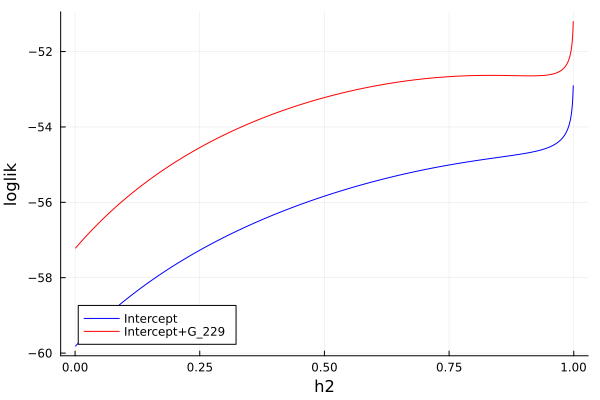

In [54]:
plot(collect(1:999).*0.001, ell_null, xlabel = "h2", ylabel = "loglik", label = "Intercept", color = "blue", legend=:bottomleft)
#scatter!([maxima_null[1]], [maxima_null[2]])
plot!(collect(1:999).*0.001, ell_markerID, xlabel = "h2", ylabel = "loglik", label = ("Intercept+"*"G_$markerID"), color = "red")
#scatter!([maxima_alt[1]], [maxima_alt[2]])

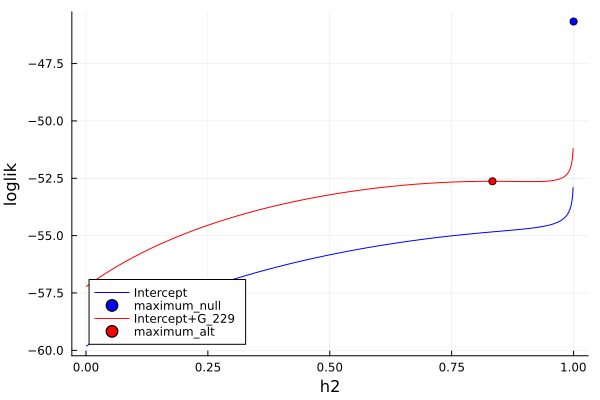

In [55]:
plot(collect(1:999).*0.001, ell_null, xlabel = "h2", ylabel = "loglik", label = "Intercept", color = "blue", legend=:bottomleft)
scatter!([maxima_null[1]], [maxima_null[2]], label = "maximum_null", color = "blue")
plot!(collect(1:999).*0.001, ell_markerID, xlabel = "h2", ylabel = "loglik", label = ("Intercept+"*"G_$markerID"), color = "red")
scatter!([maxima_alt[1]], [maxima_alt[2]], label = "maximum_alt", color = "red")

### After correction using a noninformative prior:

In [56]:
prior = [var(pheno_108), 0.1];

In [57]:
results_t108_alt_bc = scan(pheno_108, geno, kinship_Gc; 
                            prior_variance = prior[1], prior_sample_size = prior[2], 
                            assumption = "alt"); # without correction

We then see that after correction no LOD scores are below zero...

In [58]:
any(results_t108_alt_bc.lod .< 0.0)

false

In [59]:
maxima_null_bc = (results_t108_alt_bc.h2_null, 
                    getLL(pheno_108, geno, kinship_Gc, markerID, results_t108_alt_bc.h2_null; prior = prior).ll_null)

(0.8703228317949545, -55.02752290588979)

In [60]:
maxima_alt_bc = (results_t108_alt_bc.h2_each_marker[markerID], 
                    getLL(pheno_108, geno, kinship_Gc, markerID, results_t108_alt_bc.h2_each_marker[markerID]).ll_markerID)

(0.7724379371272726, -52.64985519101466)

In [61]:
issue_results_bc = map(x -> getLL(pheno_108, geno, kinship_Gc, blackSwans[1], x; prior = prior), collect(1:999).*0.001);

In [62]:
ell_null_bc = zeros(999);
ell_markerID_bc = zeros(999);
for k in 1:999 
    ell_null_bc[k] = issue_results_bc[k].ll_null;
    ell_markerID_bc[k] = issue_results_bc[k].ll_markerID;
end

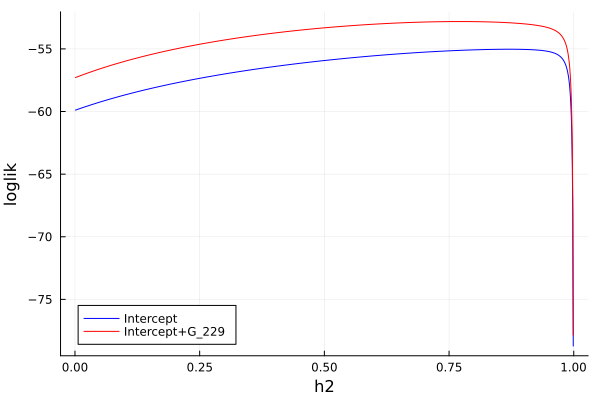

In [63]:
plot(collect(1:999).*0.001, ell_null_bc, xlabel = "h2", ylabel = "loglik", label = "Intercept", color = "blue", legend=:bottomleft)
#scatter!([maxima_null_bc[1]], [maxima_null_bc[2]])
plot!(collect(1:999).*0.001, ell_markerID_bc, xlabel = "h2", ylabel = "loglik", label = ("Intercept+"*"G_$markerID"), color = "red")
#scatter!([maxima_alt_bc[1]], [maxima_alt_bc[2]])

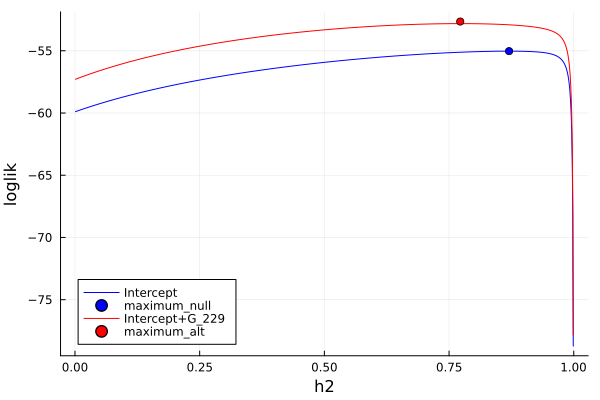

In [64]:
plot(collect(1:999).*0.001, ell_null_bc, xlabel = "h2", ylabel = "loglik", label = "Intercept", color = "blue", legend=:bottomleft)
scatter!([maxima_null_bc[1]], [maxima_null_bc[2]], label = "maximum_null", color = "blue")
plot!(collect(1:999).*0.001, ell_markerID_bc, xlabel = "h2", ylabel = "loglik", label = ("Intercept+"*"G_$markerID"), color = "red")
scatter!([maxima_alt_bc[1]], [maxima_alt_bc[2]], label = "maximum_alt", color = "red")

### Runtime Improvement:

In [65]:
?fitlmm

search: fitlmm FisherNoncentralHypergeometric



fitlmm: fit linear mixed model

y: 2-d array of (rotated) phenotypes X: 2-d array of (rotated) covariates lambda: 1-d array of eigenvalues reml: boolean indicating ML or REML estimation


In [66]:
Gj = reshape(geno[:, markerID], :, 1);
(y0, X0, lambda0) = transform_rotation(pheno_108, Gj, kinship_Gc; addIntercept = true);

In [67]:
@benchmark fitlmm(y0, X0, lambda0, prior)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  61.763 μs …  29.135 ms  ┊ GC (min … max):  0.00% … 99.50%
 Time  (median):     70.951 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   89.729 μs ± 622.504 μs  ┊ GC (mean ± σ):  16.88% ±  2.44%

  ▁▃▅▅▅▆█▆▄▃▂▁▁▁                                               ▁
  ██████████████████▇▇▇▆▇▆▆▇▇▇▆▆▆▆▆▇▆█▇▅▇▆▅▆▅▅▆▅▄▄▅▄▄▅▅▅▃▄▅▄▃▃ █
  61.8 μs       Histogram: log(frequency) by time       147 μs <

 Memory estimate: 118.70 KiB, allocs estimate: 255.

In [68]:
@benchmark fitlmm(y0, X0, lambda0, [0.0, 0.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   73.120 μs …  26.827 ms  ┊ GC (min … max):  0.00% … 99.42%
 Time  (median):      83.829 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   104.075 μs ± 667.346 μs  ┊ GC (mean ± σ):  18.07% ±  2.81%

            █▃ ▂ ▂                                               
  ▁▂▃▄▄▅▅▅█▆████▅█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  73.1 μs          Histogram: frequency by time          131 μs <

 Memory estimate: 148.41 KiB, allocs estimate: 319.

In [69]:
@benchmark scan_alt(pheno_108, geno, kinship_Gc, prior, true)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  854.886 ms … 944.234 ms  ┊ GC (min … max): 17.35% … 18.50%
 Time  (median):     888.300 ms               ┊ GC (median):    19.04%
 Time  (mean ± σ):   890.934 ms ±  29.906 ms  ┊ GC (mean ± σ):  18.48% ±  1.23%

  █           █         ██    █                               █  
  █▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁██▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  855 ms           Histogram: frequency by time          944 ms <

 Memory estimate: 1.18 GiB, allocs estimate: 2622737.

In [70]:
@benchmark scan_alt(pheno_108, geno, kinship_Gc, [0.0, 0.0], true)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.956 s …   2.053 s  ┊ GC (min … max): 18.96% … 18.83%
 Time  (median):     1.967 s              ┊ GC (median):    18.86%
 Time  (mean ± σ):   1.992 s ± 53.242 ms  ┊ GC (mean ± σ):  18.68% ±  0.37%

  █     █                                                 █  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.96 s         Histogram: frequency by time        2.05 s <

 Memory estimate: 2.60 GiB, allocs estimate: 5790567.